## Merton Model (Jumps)

We consider a model with log-normal jumps: the random variables log(1 + Yi) are Gaussian with mean $µ_J$ and of variance $σ^2_J$.

We can use the following default numerical values: S0 = 100, r = 0.05, σ = 0.20, K = 100, T = 2, λ˜ = 2, µJ = −0.02 et σJ = 0.2

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# Parameters
S0 = 100
K = 100
T = 2
r = 0.05
sigma = 0.20
lmbda = 2       # Jump intensity
mu_J = -0.02    # Mean of log jumps
sigma_J = 0.2   # Standard deviation of log jumps

# Black-Scholes
def call_bs(S, K, T, r, sigma):
    if T <= 0:
        return np.maximum(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

### 1. Here is the explicit pricing formula for the call price in the model with jumps:


We consider in this part the following modification of the Black & Scholes model:

$$S_t = αS_t dt + σS_t dB_t + S_t−d(Q_t − λβt)
= (α − λβ)S_t dt + σS_t dB_t + S_{t−}dQ$$

The solution of this dynamics is given by Itô's formula for jump processes (1D case, excluding time):

$$
f(X_t) = f(X_0) + \int_0^t f'(X_s) dX_s^c + \frac{1}{2} \int_0^t f''(X_s) d[X^c]_s + \sum_{0 < s \le t} \left( f(X_s) - f(X_{s-}) \right)
$$

By applying this to Log(St):

$$d(\ln{S_t}) = d(\ln{S_t})^c + d(\ln{S_t})^{saut}$$

with,

$$d(\ln{S_t})^c = (\alpha - \beta\lambda - \frac{\sigma^2}{2})dt + \sigma B_t $$
$$(\ln{S_t})^{saut} = \sum_{0 < s \le t} \left( \ln(X_s) - \ln(X_{s-}) \right) = \sum_{i=1}^{N_t}( 1 + Y_{i})
$$

then

$$
S_t = S_0 \exp\left( \left(\alpha - \beta\lambda - \frac{\sigma^2}{2}\right)t + \sigma B_t \right) \prod_{i=1}^{N_t}(1+Y_i)
$$


The dynamics of the asset under the risk-neutral probability Q is then given by:
$$St​=S0​ \exp{((r−\tilde{\beta}\tilde{\lambda}​−2σ^2​)t+σB_t​})\prod_{i=1}^{N_t}(1+Yi​)$$

where Nt​ is a Poisson process with intensity λ and $log(1+Yi​)∼N(μ_J​,σ_J^2​)$.

(by performing the change of measure from slide 7.13)


We then write the Payoff conditioned on the number of jumps:

$$
C_{Merton} = \sum_{n=0}^{\infty} \underbrace{P(N_T = n)}_{\text{Proba Poisson}} \times \underbrace{E^Q[e^{-rT}(S_T - K)^+ \mid N_T=n]}_{\text{Call pice with } n \text{jumps}}
$$

Finally,

$$
C(S_t, K, T) = \sum_{n=0}^{\infty} \frac{e^{-\tilde{\lambda} \tau} (\tilde{\lambda} \tau)^n}{n!} C_{BS}(S_n, K, \tau, r_n, \sigma_n)
$$

with,
\begin{cases}
\tau = T - t \\
\sigma_n = \sqrt{\sigma^2 + \frac{n \sigma_J^2}{\tau}} \\
r_n = r - \tilde{\lambda}\tilde{\beta} + \frac{n(\mu_J + \sigma_J^2/2)}{\tau} \\
S_n = S_t \quad
\end{cases}


In [2]:
# Merton Model Function
def merton_price_exact(S, K, T, r, sigma, lmbda, mu_J, sigma_J, N_trunc=50):
    # Compensator
    beta = np.exp(mu_J + 0.5 * sigma_J**2) - 1
    price = 0

    for n in range(N_trunc):
        # CORRECTION HERE: math.factorial instead of np.math.factorial
        prob_n = np.exp(-lmbda * T) * (lmbda * T)**n / math.factorial(n)

        # Adjusted parameters for n jumps
        sigma_n = np.sqrt(sigma**2 + n * sigma_J**2 / T)
        r_n = r - lmbda * beta + (n * (mu_J + 0.5 * sigma_J**2)) / T

        # Add to price
        price += prob_n * call_bs(S, K, T, r_n, sigma_n)

    return price

### 2. We study the convergence of the price as a function of the number of terms in the sum.

Calcul en cours...


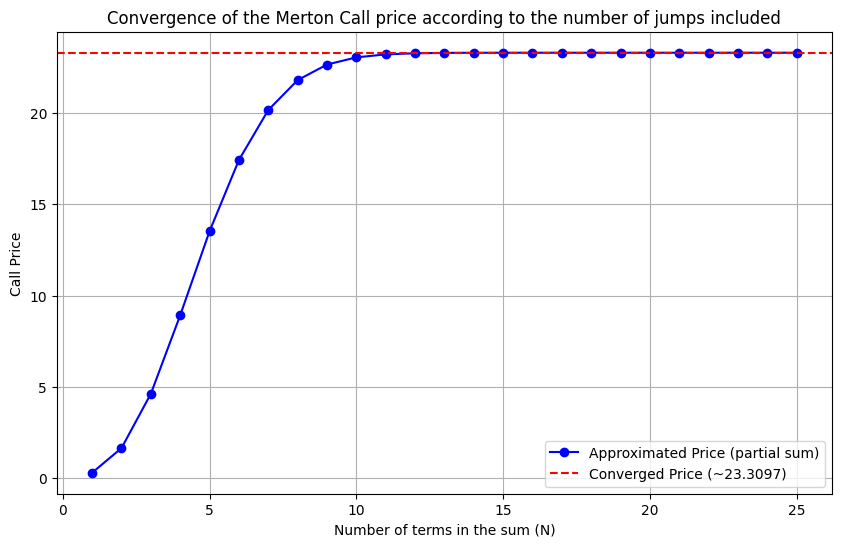

Final converged price : 23.3097


In [3]:
def etude_convergence():
    print("Calcul en cours...")

    # We test the sum by stopping from 1 to 25 terms
    N_range = range(1, 26)
    prices = []

    for n in N_range:
        # Price calculation with n terms
        p = merton_price_exact(S0, K, T, r, sigma, lmbda, mu_J, sigma_J, N_trunc=n)
        prices.append(p)

    # Calculation of an "exact" reference (with 50 terms)
    ref_price = merton_price_exact(S0, K, T, r, sigma, lmbda, mu_J, sigma_J, N_trunc=50)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(N_range, prices, 'b-o', label='Approximated Price (partial sum)')
    plt.axhline(y=ref_price, color='r', linestyle='--', label=f'Converged Price (~{ref_price:.4f})')

    plt.title("Convergence of the Merton Call price according to the number of jumps included")
    plt.xlabel("Number of terms in the sum (N)")
    plt.ylabel("Call Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final converged price : {ref_price:.4f}")

# Execution of the study
etude_convergence()

The price seems to converge when the number of jumps exceeds 10.

### 3. We implement the pricing of the call price in the model with jumps using the Monte Carlo method and verify its convergence to the exact price.

In [4]:
# Parameter reminder if needed
S0, K, T, r, sigma = 100, 100, 2, 0.05, 0.20
lmbda, mu_J, sigma_J = 2, -0.02, 0.2

def merton_mc_pricing(S, K, T, r, sigma, lmbda, mu_J, sigma_J, n_sims=100000):
    """
    Prices a European Call under the Merton model using vectorized Monte Carlo.
    """
    np.random.seed(42)  # For reproducibility

    # 1. Draw the number of jumps for each simulation (Poisson Distribution)
    # n_jumps is a vector of size n_sims
    n_jumps = np.random.poisson(lmbda * T, n_sims)

    # 2. Simulation of the continuous part (Brownian Motion)
    # Z ~ N(0, 1)
    z = np.random.normal(0, 1, n_sims)
    diffusion_part = (r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z

    # 3. Simulation of the jump part (Sum of log-normals)
    # Vectorized trick: Sum of k normal distributions N(mu, sig^2) -> N(k*mu, k*sig^2)
    # We draw a standard Gaussian noise for the jump
    z_jump = np.random.normal(0, 1, n_sims)

    # The compensator beta = E[Y]
    beta = np.exp(mu_J + 0.5 * sigma_J**2) - 1

    # Jump compensation drift
    jump_drift = -lmbda * beta * T

    # Random part of jumps: total mean + total standard deviation * noise
    # If n_jumps is 0, this term will be 0
    total_jump_log_return = (n_jumps * mu_J) + (np.sqrt(n_jumps) * sigma_J * z_jump)

    # 4. Calculation of the final price ST
    # ST = S0 * exp(Continuous Part + Jump Drift + Random Jump Part)
    ST = S * np.exp(diffusion_part + jump_drift + total_jump_log_return)

    # 5. Payoff Calculation and Discounting
    payoffs = np.maximum(ST - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)

    # Standard error (95% Confidence Interval)
    std_dev = np.std(payoffs)
    std_error = 1.96 * std_dev / np.sqrt(n_sims)

    return price, std_error

# --- Convergence check ---

# 1. Exact price calculation (reference)
price_ref = merton_price_exact(S0, K, T, r, sigma, lmbda, mu_J, sigma_J, N_trunc=50)

# 2. Monte Carlo calculation with 200,000 simulations
price_mc, error_mc = merton_mc_pricing(S0, K, T, r, sigma, lmbda, mu_J, sigma_J, n_sims=200000)

print(f"{'Méthode':<15} | {'Prix':<10} | {'Intervalle de Confiance (95%)'}")
print("-" * 60)
print(f"{'Formule Exacte':<15} | {price_ref:.4f}     | -")
print(f"{'Monte Carlo':<15} | {price_mc:.4f}     | [{price_mc - error_mc:.4f}, {price_mc + error_mc:.4f}]")

# Validation test
if abs(price_mc - price_ref) < error_mc:
    print("\n Success: The Monte Carlo price converges to the exact price.")
else:
    print("\n⚠️ Warning: Increase the number of simulations.")

Méthode         | Prix       | Intervalle de Confiance (95%)
------------------------------------------------------------
Formule Exacte  | 23.3097     | -
Monte Carlo     | 23.2100     | [23.0058, 23.4142]

 Success: The Monte Carlo price converges to the exact price.


### 4. Plot the implied volatility smile generated by the jump model and analyze it.

Calcul du smile en cours...


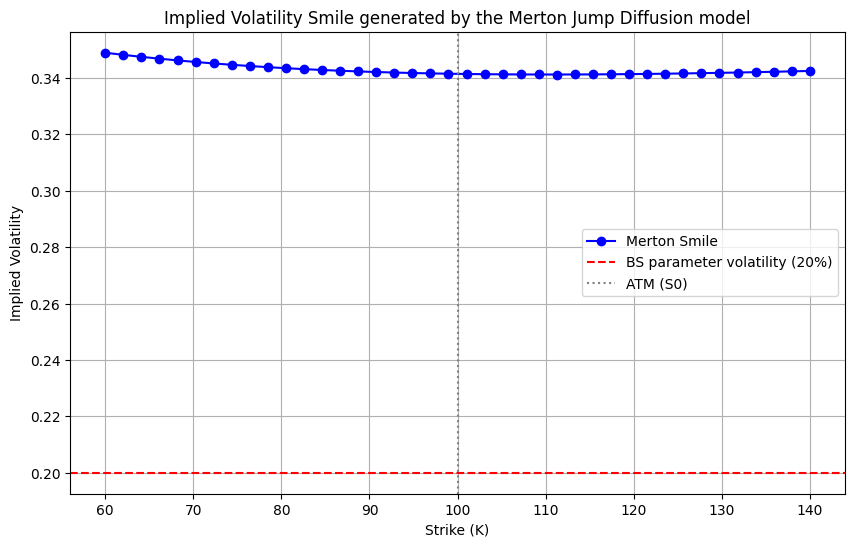

In [5]:
# --- 1. Implied Volatility Inversion Function ---
def implied_volatility(price, S, K, T, r):
    """
    Finds the implied volatility sigma such that BS(sigma) = price.
    """
    # If the price is less than the intrinsic value, the IV is undefined (arbitrage)
    intrinsic = np.maximum(S - K*np.exp(-r*T), 0)
    if price <= intrinsic:
        return np.nan

    def objective(sigma_test):
        return call_bs(S, K, T, r, sigma_test) - price

    # We search for the solution between 1% and 200% volatility
    try:
        return brentq(objective, 1e-5, 2.0)
    except ValueError:
        return np.nan

# --- 2. Smile Generation ---
def plot_volatility_smile():
    print("Calcul du smile en cours...")

    # Strike Range: from 50 to 150 (around S0=100)
    strikes = np.linspace(60, 140, 40)
    implied_vols = []

    for k_val in strikes:
        # A. We calculate the "True Price" with the Merton model
        # We use our exact function (N=50 is sufficient)
        merton_p = merton_price_exact(S0, k_val, T, r, sigma, lmbda, mu_J, sigma_J, N_trunc=50)

        # B. We invert Black-Scholes to find the Implied Volatility
        iv = implied_volatility(merton_p, S0, k_val, T, r)
        implied_vols.append(iv)

    # --- 3. Plot ---
    plt.figure(figsize=(10, 6))

    # Merton Smile Curve
    plt.plot(strikes, implied_vols, 'b-o', label='Merton Smile')

    # Black-Scholes Reference (Constant volatility of the base model)
    plt.axhline(y=sigma, color='r', linestyle='--', label=f'BS parameter volatility ({sigma:.0%})')

    # ATM (At The Money) mark
    plt.axvline(x=S0, color='gray', linestyle=':', label='ATM (S0)')

    plt.title("Implied Volatility Smile generated by the Merton Jump Diffusion model")
    plt.xlabel("Strike (K)")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_volatility_smile()

The volatility of the jump model is higher than the volatility of the Black & Scholes model (price jumps mechanically increase volatility). Moreover, the curvature of the volatility smile is very slight.
